In [1]:
import pandas as pd

In [2]:
! pip install openpyxl

In [3]:
# 读入数据
df = pd.read_excel('jinmao1.xlsx')

In [4]:
df.head()

,评论,sentiment
0,@蜡笔小新 好可爱好想捏捏它,1
1,哇塞 小金毛 好想养一只,1
2,@熙熙 非常可爱！非常！,1
3,你长得真可爱,1
4,好可爱,1


In [5]:
df = df.astype({'评论':'unicode'}) 

In [6]:
# 调用软件包snownlp对正文列进行情感分析，将结果存储在sentiment_snownlp列中

In [7]:
!pip install snownlp

In [8]:
!pip install jieba

In [9]:
import jieba
from snownlp import SnowNLP
import numpy as np

In [10]:
def sentiment_snownlp(text):
    s = SnowNLP(text)
    return s.sentiments

In [11]:
df['评论'].apply(sentiment_snownlp)

0     0.994507
1     0.412445
2     0.895579
3     0.838877
4     0.878968
        ...   
95    0.031280
96    0.309996
97    0.784165
98    0.032185
99    0.022571
Name: 评论, Length: 100, dtype: float64

In [12]:
df.head()

,评论,sentiment
0,@蜡笔小新 好可爱好想捏捏它,1
1,哇塞 小金毛 好想养一只,1
2,@熙熙 非常可爱！非常！,1
3,你长得真可爱,1
4,好可爱,1


In [13]:
df['评论'].apply(sentiment_snownlp)
df['sentiment_snownlp'] = df['评论'].apply(sentiment_snownlp).apply(lambda x:1 if x >0.5 else 0)

In [14]:
# 根据 sentiment 和 sentiment_snownlp ，测情感分析判断准确率
from sklearn.metrics import accuracy_score

In [15]:
accuracy = accuracy_score(df['sentiment'], df['sentiment_snownlp'])

In [16]:
print(f"准确率为：{accuracy}")

准确率为：0.84


In [17]:
T1=df['sentiment_snownlp'].value_counts();T1

1    69
0    31
Name: sentiment_snownlp, dtype: int64

In [18]:
T1/sum(T1)*100

1    69.0
0    31.0
Name: sentiment_snownlp, dtype: float64

In [19]:
print(f"百分比: {T1/sum(T1)*100}")

百分比: 1    69.0
0    31.0
Name: sentiment_snownlp, dtype: float64


In [20]:
# 按照 sentiment_snownlp 取值，把 df 分成 positive 和 negative 两个数据框
positive = df[df['sentiment_snownlp']==1]
negative = df[df['sentiment_snownlp']==0]

In [21]:
# 对 positive 数据框，对评论做 lda 分析。首先测定类别个数，然后做出可视化图形
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [22]:
# 对 positive 数据框的正文列进行分词，去除停用词
import jieba
import jieba.analyse
import jieba.posseg as pseg
import re

In [23]:
def chinese_word_cut(mytext):
    return " ".join(jieba.lcut(mytext))

In [24]:
# 对 positive 数据框的评论列进行分词
positive['评论'] = positive['评论'].apply(jieba.lcut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86198\AppData\Local\Temp\jieba.cache
Loading model cost 0.780 seconds.
Prefix dict has been built successfully.
C:\Users\86198\AppData\Local\Temp\ipykernel_15200\629945185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive['评论'] = positive['评论'].apply(jieba.lcut)


In [25]:
import urllib.request

In [26]:
def remove_stop_words(mytext):
    stopwords = pd.read_csv("stopwords.txt", index_col=False, quoting=3, sep="\t", names=['stopword'], encoding='utf-8')
    stopwords = stopwords['stopword'].values
    mytext = re.sub('[^\w\s]', '', mytext)
    mytext = re.sub('\s+', ' ', mytext)
    words = mytext.split()
    words = [w for w in words if not w in stopwords]
    return " ".join(words)

In [28]:
positive.head()

,评论,sentiment,sentiment_snownlp
0,"[@, 蜡笔小新, , 好, 可爱, 好, 想, 捏, 捏, 它]",1,1
2,"[@, 熙熙, , 非常, 可爱, ！, 非常, ！]",1,1
3,"[你, 长得, 真, 可爱]",1,1
4,"[好, 可爱]",1,1
5,"[@, 小, 陈, , @, 快乐, 冠军, , @, 明所, 将, 往, , @, ...",1,1


In [29]:
# 对 positive 数据框的评论列进行向量化
vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
X = vectorizer.fit_transform(positive['评论'].apply(lambda x: ' '.join(x)))  

In [30]:
X

<69x189 sparse matrix of type '<class 'numpy.int64'>'
	with 381 stored elements in Compressed Sparse Row format>

In [31]:
print(X[0])

  (0, 158)	1
  (0, 72)	2
  (0, 44)	1
  (0, 95)	1
  (0, 103)	2
  (0, 79)	1


In [32]:
# 测定类别个数
n_topics = None

In [33]:
# 测定 perplexity 等指标变化
perplexity_list = []
for i in range(2, 20):
    lda = LatentDirichletAllocation(n_components=i, random_state=0)
    lda.fit(X)
    perplexity_list.append(lda.perplexity(X))

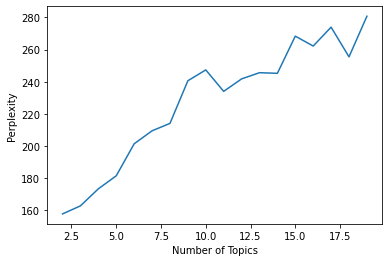

In [34]:
plt.plot(range(2, 20), perplexity_list)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.show()

In [35]:
# 根据 perplexity 等指标变化，选择最优的类别个数
best_n_topics = perplexity_list.index(min(perplexity_list)) + 2

In [36]:
# 使用最优的类别个数，做 lda 分析
random_state = 0
lda = LatentDirichletAllocation(n_components=best_n_topics, 
                                random_state=random_state)
lda.fit(X)

LatentDirichletAllocation(n_components=2, random_state=0)

Topic 0:
['金毛', '很', '狗狗', '的', '了', '太', '我', '喜欢', '啦', '可爱']


C:\Users\86198\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


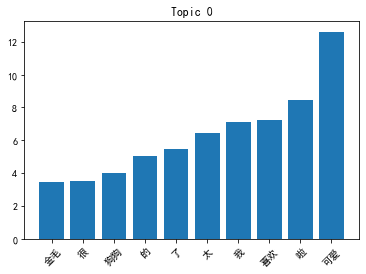

C:\Users\86198\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 1:
['一下', '鸡毛', '亲', '什么', '啊', '小', '小狗', '的', '可爱', '好']


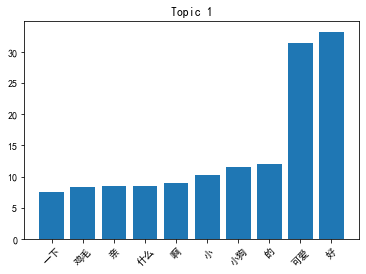

In [37]:
# 可视化图形
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])
    plt.bar([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]], topic[topic.argsort()[-10:]])
    plt.xticks(rotation=45)
    plt.title(f"Topic {i}")
    # plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.show()

In [38]:
!pip install pyLDAvis

In [39]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
x = pyLDAvis.sklearn.prepare(lda, X, vectorizer)
pyLDAvis.save_html(x, 'lda_jinmao10.html')

C:\Users\86198\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\86198\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [40]:
# 对 negative 数据框，对评论做 lda 分析
negative['评论'] = negative['评论'].apply(jieba.lcut)

C:\Users\86198\AppData\Local\Temp\ipykernel_15200\1792254544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative['评论'] = negative['评论'].apply(jieba.lcut)


In [41]:
vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
Y = vectorizer.fit_transform(negative['评论'].apply(lambda x: ' '.join(x)))

In [42]:
n_topics = None

In [43]:
perplexity_list = []
for i in range(2, 20):
    lda = LatentDirichletAllocation(n_components=i, random_state=0)
    lda.fit(Y)
    perplexity_list.append(lda.perplexity(Y))

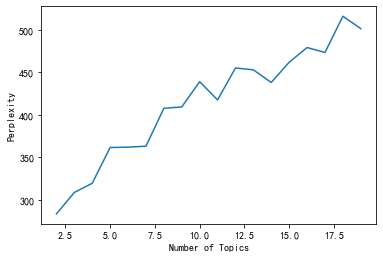

In [44]:
plt.plot(range(2, 20), perplexity_list)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.show()

In [45]:
best_n_topics = perplexity_list.index(min(perplexity_list)) + 2

In [46]:
random_state = 0
lda = LatentDirichletAllocation(n_components=best_n_topics, 
                                random_state=random_state)
lda.fit(Y)

LatentDirichletAllocation(n_components=2, random_state=0)

Topic 0:
['麻烦', '多', '可爱', '养', '金毛', '毛', '掉', '还', '吃', '的']


C:\Users\86198\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


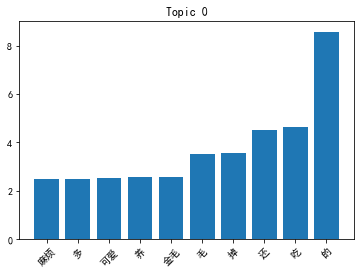

Topic 1:
['吃', '毛', '小', '它', '拉', '啊', '口水', '的', '都', '了']


C:\Users\86198\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


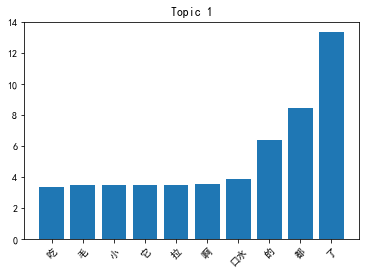

In [47]:
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])
    plt.bar([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]], topic[topic.argsort()[-10:]])
    plt.xticks(rotation=45)
    plt.title(f"Topic {i}")
    # plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    plt.show()

In [48]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
y = pyLDAvis.sklearn.prepare(lda, Y, vectorizer)
pyLDAvis.save_html(y, 'lda_jinmao11.html')

C:\Users\86198\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\86198\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
